# Chance-constrained programming: portfolio optimization example

In [18]:
# ENV["GUROBI_HOME"] = "/Library/gurobi952/macos_universal2/"
# # import Pkg
# Pkg.add("Gurobi")
# Pkg.build("Gurobi")
# Pkg.add("Dates")
# Pkg.add("CSV")
# Pkg.add("DataFrames")

   Resolving package versions...


    Updating `~/.julia/environments/v1.9/Project.toml`
⌃ [2e9cd046] + Gurobi v0.11.3
    Updating `~/.julia/environments/v1.9/Manifest.toml`
⌃

 [2e9cd046] + Gurobi v0.11.3
        Info Packages marked with ⌃ have new versions available and may be upgradable.


    Building Gurobi → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/87c018cbd2fd33e6d2462d486abee53a27c91c91/build.log`


In [119]:
using LinearAlgebra
using JuMP
using HiGHS, Gurobi
using Distributions
using Random
using CSV, DataFramesMeta
using Dates
using Statistics
using Plots

## HW2

Sample Average Approximation Method for Chance Constrained Programming : Theory and Applications”, 2009, Section 3, en s ́electionnant 10 actifs depuis la base de donn ́ees disponible sur Kaggle `a l’adresse https: //www.kaggle.com/datasets/jacksoncrow/stock-market-dataset.

Note : vous pouvez partir de https://www.kaggle.com/code/artemburenok/ stock-analysis-monte-carlo-build-portfolio pour analyser les donn ́ees.

Adapted from Stephen Boyd and Lieven Vandenberghe, "Convex Optimization", Cambridge University Press, 2004, Section 4.7.6, p. 187.

We consider an investiment portfolio with $n$ assets and random returns, except the last one. We assume that the $n-1$ first returns follow a multivariate distribution with known mean and covariance matrix. The last asset is a risk-free investment product, with a fixed return.

The assets characteristics are detailed below.

In [11]:
company_list = ["MMM", "AMZN", "CAT", "AI", "AIR", "AM", "TWTR", "RIO", "MSFT", "BP"]
n = length(company_list)


10

## Data Pipeline

In [12]:
dir_path = "../data/stocks/"
companies = Dict{String, DataFrame}()
# companies = Dict{}()
for company in company_list
    fn = dir_path * company * ".csv"
    companies[company] = CSV.read(fn, DataFrame, select=["Date", "Adj Close"])
end

In [16]:
# If Initialize to same start and end date  
first_end, last_start = DateTime(2023, 11, 14), DateTime(1900, 11, 14)
for (company, df) in companies

    start_date = minimum(df.Date)
    end_date = maximum(df.Date)

    println("$(company): $(start_date) to $(end_date)")
    if start_date > last_start
        last_start = start_date
        println("last_start: $(start_date)")
    end
    if end_date < first_end
        first_end = end_date
        println("first_end: $(end_date)")
    end
end

for (company, df) in companies
    df = df[df.Date .>= last_start, :]
    df = df[df.Date .<= first_end, :]
    if company == "CAT"    
        df = deleteat!(df, findall(df.Date .== Date(2016, 01, 18))) # CAT data contains extra date
    end
    companies[company] = df
end

MSFT: 1986-03-13 to 2020-04-01
last_start: 1986-03-13
first_end: 2020-04-01
AMZN: 1997-05-15 to 2020-04-01
last_start: 1997-05-15
TWTR: 2013-11-07 to 2020-04-01
last_start: 2013-11-07
CAT: 1962-01-02 to 2020-04-01
RIO: 1990-06-28 to 2020-04-01
AI: 1997-12-23 to 2020-04-01
MMM: 1970-01-02 to 2020-04-01
BP: 1977-01-03 to 2020-04-01
AM: 2014-11-05 to 2020-04-01
last_start: 2014-11-05
AIR: 1980-03-17 to 2020-04-01


In [18]:
for (c, df) in companies
    println("$(c): $(size(df))")
end

MSFT: (1360, 3)
AMZN: (1360, 3)
TWTR: (1360, 3)
CAT: (1360, 3)
RIO: (1360, 3)
AI: (1360, 3)
MMM: (1360, 3)
BP: (1360, 3)
AM: (1360, 3)
AIR: (1360, 3)


In [23]:
# Check dates alignment
row_cnt = 0
test_df = DataFrame()
for (c, df) in companies
    if row_cnt == 0 
        println("Set row cnt to $(size(df)[1]) with  $(c)")
        row_cnt = size(df)[1]
        test_df = df
    elseif row_cnt != size(df)[1]
        println("$(c) has $(size(df)[1]) rows")
        println(setdiff(Set(df[!, :Date]), Set(test_df[!, :Date])))
    end
end


Set row cnt to 1360 with  MSFT


In [24]:
# Calculate returns
for (company, df) in companies
    df[!, :Return] = [0.0; diff(df[!, :"Adj Close"]) ./ df[1:end-1, :"Adj Close"]]
    companies[company] = df
end

In [25]:
# Calculate mean and covariance
mean_return = zeros(length(company_list))
covariance = zeros(length(company_list), length(company_list))

df = companies["MMM"]
println("mean: $(mean(df[!, :Return]))")

mean: 9.560212265787485e-5


In [47]:
function calc_mean_cov(N, companies)
    # Calculate mean and covariance

    company_list = collect(keys(companies))

    if N == 0
        N = size(companies[company_list[1]])[1]
    end

    μ = zeros(length(company_list))
    Σ = zeros(length(company_list), length(company_list))
    
    for (i, company) in enumerate(company_list)

        μ[i] = mean(companies[company][!, :Return])

        for (j, company2) in enumerate(company_list)
            Σ[i, j] = cov(companies[company][!, :Return], companies[company2][!, :Return])
            if abs(Σ[i, j]) > .99; println("$(company), $(company2)"); end
        end
    end

    return μ, Σ
end

calc_mean_cov (generic function with 1 method)

In [53]:
d = MvNormal(μ, Σ)
# logd = MvLogNormal(d)
# A = Σ^0.5

FullNormal(
dim: 10
μ: [0.0010819336393733032, 0.001546874801099191, 0.00014738046874086257, 0.0003835047655473332, 0.00041097753363276816, -0.0008839980496428187, 9.560212265787485e-5, 2.8847900048423212e-5, -0.001278955505896213, 9.30177051892924e-5]
Σ: [0.00029105514069851856 0.00020396057695653096 … 0.00010249529173229295 0.00016290419821485513; 0.00020396057695653096 0.0003584096475995049 … 0.00011207567312295784 0.00011858449899957392; … ; 0.00010249529173229295 0.00011207567312295784 … 0.0008363727875585156 0.000237691997543317; 0.00016290419821485513 0.00011858449899957392 … 0.000237691997543317 0.0007672930076023039]
)


In [128]:
# Estimate the probability to have a negative return and the resulting expected shortfall.
function expectedshortfall(p:: Vector, d:: Distribution, M:: Int = 1000000) # M = 1000000
    
    loss = 0
    vloss = 0
    for i = 1:M
        ξ = rand(d)  #[rand(d); μ[n]]
        ret = dot(p, ξ)
        if ret < 0
            loss += 1
            vloss += ret
        end
    end

    return loss/M, vloss/loss
    
end

expectedshortfall (generic function with 2 methods)

## Model 1/7
SAA with
- Normal
- γ = 0
- $\alpha$ = .1
- $\beta$ = .01
- N = [30, 40, 50, ..., 200] + 183      (Sample Sizes)

#

In [65]:
length(company_list) == length(p[1:n]) == length(μ)

true

In [144]:
maxloss = 0

α = 0.1
z = 1/quantile(Normal(0,1), α)

-0.7803041460723791

In [145]:

Ns = [collect(30:10:100); 183; 1000; 1300]
loss_probs = zeros(length(Ns))
objective_vals = zeros(length(Ns))
for (i, N) in enumerate(Ns)
    μ, Σ = calc_mean_cov(N, companies)
    A = Σ^0.5

    m = Model(Gurobi.Optimizer)
    @variable(m, p[1:n] >= 0.01)
    @constraint(m, sum(p[i] for i = 1:n) <= 1)
    @objective(m, Max, sum(p[i]*μ[i] for i = 1:n))
    # || x || <= t, t >= 0
    # https://jump.dev/JuMP.jl/stable/reference/constraints/#JuMP.SecondOrderCone
    @constraint(m, [z*(-maxloss+sum(μ[i]*p[i] for i = 1:n)); A*p[1:n]] in SecondOrderCone())

    optimize!(m)

    # objective_vals[i] = objective_value(m)
    loss_probs[i], objective_vals[i] = expectedshortfall(value.(p), d)
end

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[x86])
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 12 rows, 21 columns and 131 nonzeros
Model fingerprint: 0x75781d04
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [2e-05, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [3e-05, 2e-03]
  Bounds range     [1e-01, 1e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 12 rows, 21 columns, 131 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.600e+01
 Factor NZ  : 7.800e+01
 Factor Ops : 6.500e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.11521608e-04  1.33097273e-04  9.16e-01 

In [143]:
objective_vals

21-element Vector{Float64}:
 -1.4746447094305332e-9
 -1.4753079744231103e-9
 -1.4783957550541489e-9
 -1.4762777488788281e-9
 -1.479493996248263e-9
 -1.479399420602415e-9
 -1.4782636030928584e-9
 -1.4762569705620764e-9
 -1.4780720534806446e-9
 -1.4764698079487837e-9
  ⋮
 -1.4790999596951407e-9
 -1.47692617980347e-9
 -1.4776841124378596e-9
 -1.4766337836133784e-9
 -1.478972430634609e-9
 -1.477087125195125e-9
 -1.4781826912003348e-9
 -1.4780995772915597e-9
 -1.4770182080386816e-9

In [147]:
loss_probs

21-element Vector{Float64}:
 0.459639
 0.461196
 0.460583
 0.460296
 0.460953
 0.460381
 0.460046
 0.461216
 0.460892
 0.460201
 ⋮
 0.460353
 0.461121
 0.459743
 0.460418
 0.460618
 0.460967
 0.460443
 0.460633
 0.459551

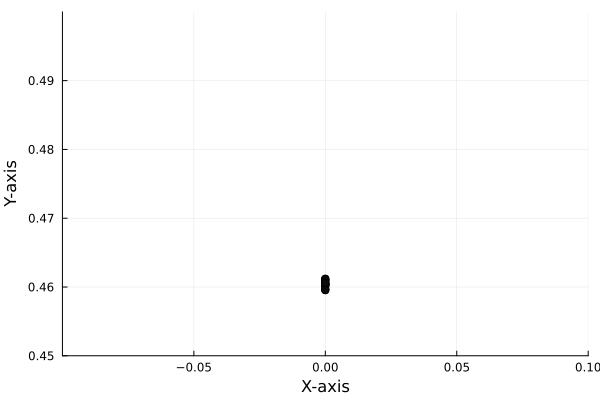

In [146]:
scatter(objective_vals, loss_probs, c=:grays, marker=:circle, xlabel="X-axis", ylabel="Y-axis", legend=false)
xlims!(-.1,.1)  # Set the X-axis limits from 0 to 6
ylims!(.45, .5) 

## Model 2/7
SAA with
- LogNormal
- γ = 0
- $\alpha$ = .1
- $\beta$ = .01
- N = [30, 40, 50, ..., 200] + 183      (Sample Sizes)